## 작업 배경
+ 비슷한 뉴스를 추천/검색해주는 서비스 (뉴스 body 정보 기반)
+ 뉴스 본문의 유사도를 비교해서, 뉴스 title로 비슷한 뉴스 찾기<br><br>

+ k-means는 유사한 뉴스 그룹끼리 그룹핑은 되지만, 사람이 각 그룹에 대해 tagging을 따로 해주어야 해서<br>
    특정 뉴스 title을 검색하면 비슷한 뉴스를 뽑아주도록 만듬

## 구현 알고리즘
+ **코사인 유사도(Cosine Similarity)**
     - 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도<br>
     - 두 벡터의 방향이 같으면 1, 직교일 때는 0, 서로 반대 방향이면 -1<br>
     - 1에 가까울 수록 유사도가 높다고 판단<br><br>
     
+ **TF-IDF(Term Frequency - Inverse Document Frequency)**
     - TF(단어 빈도) : 특정한 단어가 문서 내에 얼마나 '자주' 등장하는지를 나타내는 값. 높을수록 중요하다고 판단 
     - IDF(문서 빈도의 역수) : TF * IDF. 점수가 높은 단어일수록 다른 문서에는 많지 않고 해당 문서에서 자주 등장하는 단어


### 1. 데이터 로드, 전처리 하기

+ 기간 : 2021.01 ~ 04
+ 건수 : 18,472건
+ 전처리 : 명사 추출

In [1]:
import pandas as pd

df = pd.read_excel('C:/Users/09368/workspace/data/excel/Article_economy_202101_202104.xlsx')

print(len(df))

title  = df['title'].values.tolist()
body   = df['body'].values.tolist()
date   = df['date'].values.tolist()
source = df['source'].values.tolist()

18472


In [2]:
import re

def preprocessing(sentence):
    sentence =re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', sentence)
    return sentence

# Preprocessing (특수문자 제거)
df['body_cleaned'] = df['body'].apply(preprocessing)
df['overview']     = df['body_cleaned'].fillna(' ') # 키워드 중심 추출 위해

overview = df['overview'].values.tolist()

## 2. tf-idf 계산

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(overview)

# 본문에 대해서 tf-idf 수행
# 기사 각각의 tf-idf 값을 계산
print(tfidf_matrix.shape)

# TF-IDF 매트릭스 확인
# 데이터 갯수 : 1000, 모든 본문 뉴스를 토대로 구한 유니크한 단어의 갯수 : 56230
# 1000개 데이터의 overview에서 56230개의 단어가 쓰인 것을 볼 수 있다.

(18472, 292731)


## 3. 코사인 유사도 계산

In [4]:
"""
ex) 
문서1 : 저는 사과 좋아요
문서2 : 저는 바나나 좋아요
문서3 : 저는 바나나 좋아요 저는 바나나 좋아요

        바나나   사과   저는    좋아요
문서1   0         1       1        1
문서2   1         0       1        1
문서3   2         0       2        2 

"""

from numpy import dot
from numpy.linalg import norm
import numpy as np
def cos_sim(A, B):
    return dot(A,B) / (norm(A)*norm(B))

doc1 = np.array([0,1,1,1])
doc2 = np.array([1,0,1,1])
doc3 = np.array([2,0,2,2])

print(cos_sim(doc1,doc2))
print(cos_sim(doc2,doc3))
print(cos_sim(doc1,doc3))

0.6666666666666667
1.0000000000000002
0.6666666666666667


In [5]:
from sklearn.metrics.pairwise import linear_kernel

# 코사인 유사도 계산
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#인덱스 테이블 생성
indices = pd.Series(df[:1000].index, index= df['title'][:1000]).drop_duplicates()

print(cosine_sim)
"""
각 행과 열은 들어온 본문 데이터이며, 각 셀은 코사인 유사도 수치를 의미함
"""
print(indices.head())

[[1.         0.03528597 0.03388586 ... 0.00608131 0.00205572 0.00119064]
 [0.03528597 1.         0.02907445 ... 0.         0.00290602 0.00187008]
 [0.03388586 0.02907445 1.         ... 0.00378803 0.00672677 0.01048857]
 ...
 [0.00608131 0.         0.00378803 ... 1.         0.01133439 0.00545765]
 [0.00205572 0.00290602 0.00672677 ... 0.01133439 1.         0.3869048 ]
 [0.00119064 0.00187008 0.01048857 ... 0.00545765 0.3869048  1.        ]]
title
세진중공업 560억 규모 육상플랜트 모듈 수주           0
한국조선해양 지난해 수주액 100억 달러…목표 91% 달성    1
“경기 하락세 1분기에는 다소 완화될 듯”             2
울산 소상공인 81%는 ‘임차인’…보증금 네 번째 높아      3
공영쇼핑 ‘2021 건강하소 행복하소’ 이벤트           4
dtype: int64


In [6]:
idx= indices['한국조선해양 지난해 수주액 100억 달러…목표 91% 달성']
print(idx)

1


## 4. 비슷한 뉴스 검색(추천)

In [7]:
def get_recommendatioin(title, cosine_sim=cosine_sim):
    # 입력된 뉴스 title로부터 인덱스 가져오기
    idx= indices[title]
    
    #모든 뉴스에 대해 해당 뉴스와의 유사도
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    #유사도 따라 뉴스 정렬
    sim_scores = sorted(sim_scores,key=lambda x:x[1], reverse=True)
    
    #유사한 뉴스 10개
    sim_scores = sim_scores[1:11] 
    
    #10개의 뉴스 인덱스 받아온다
    news_indices = [i[0] for i in sim_scores]
    
    # 기존에 읽어들인 데이터에서 해당 인덱스의 값 가져옴. 스코어 열 추가(코사인 유사도 확인)
    result = df.iloc[news_indices].copy()
    result['score'] = [i[1] for i in sim_scores]
    
    del result['body']
    
    df_result = result[['title','score']]
    
    return df_result # df['title'].iloc[news_indices] #10개의 뉴스 제목 리턴


get_recommendatioin('한국조선해양 지난해 수주액 100억 달러…목표 91% 달성')

,title,score
6048,현대重 그룹 올해 수주 목표 16조원… 작년의 1.5배 규모,0.219697
9352,한국조선해양 올해 첫 수주…컨테이너선 6척,0.177582
3525,한국조선해양 올해 수주 목표 149억 달러로 설정,0.172858
13449,한국조선해양 올해 수주 목표 149억 달러로 설정,0.172858
12525,특징주한국조선해양 올해 목표 수주액 상향에 5% 급등,0.160713
4457,한국조선해양 올해 수주 목표 149억 달러 설정…작년 1.5배,0.157546
5293,한국조선해양 올해 수주 목표 149억 달러로 설정,0.143414
11184,한국조선해양 새해 벽두부터 대형 컨테이너선 6척 9000억 수주,0.136390
10519,조선업 새해에도 수주 낭보...올해 수주목표 높인다,0.135477
9705,새해부터 ‘수주릴레이’ 조선사… 실적 갱신 기대,0.134530


In [8]:
# test
get_recommendatioin('공영쇼핑 ‘2021 건강하소 행복하소’ 이벤트')

,title,score
741,공영쇼핑 2021 건강하소 행복하소 이벤트,0.699871
888,비대면 수요에 보복소비까지…신축년 기대하는 홈쇼핑 이색 이벤트 풍성,0.396550
7554,출첵하고 가소…BYC 온라인 신년 이벤트 풍성,0.168408
5476,롯데百 새해맞이 비대면 쇼핑 이벤트 연다,0.166348
893,이커머스 업체들 2021년 맞아 소·새해 행사 진행,0.165688
5774,롯데百 온라인몰서 겨울 상품 30% 할인…소프라이즈 이벤트,0.164705
6747,BYC 2021년 새해 맞이 이벤트 실시,0.158350
6310,롯데하이마트온라인쇼핑몰 새해맞이 1월 ‘빅하트세일’ 실시,0.143038
12908,마켓컬리 설 선물 얼리버드 최대 60% 할인,0.133724
12849,삼성물산 패션삼성전자 31일까지 공동 프로모션,0.128659


### [참고] K-Means
+ k-평균 알고리즘(K-means clustering algorithm)
    + 주어진 데이터를 k개의 클러스터로 묶는 알고리즘
    + 각 클러스터와 거리 차이의 분산을 최소화하는 방식으로 동작함. 
    + 이 알고리즘은 자율 학습의 일종으로, 레이블이 달려 있지 않은 입력 데이터에 레이블을 달아주는 역할을 수행함

In [9]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

def preprocessing(sentence):
    sentence =re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', sentence)
    return sentence

def kmeans(content):
    # 군집화 할 그룹의 갯수 정의
    n_clusters = 10

    # CountVectrizer로 토큰화
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(content)

    # l2 정규화
    X = normalize(X)

    # k-means 알고리즘 적용
    kmeans = KMeans(n_clusters=n_clusters).fit(X)

    # trained labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # labels에 merge
    df['labels'] = labels
    df.sort_values(by=['labels'])
    
    return df

if __name__ == '__main__':
    
    # Preprocessing (특수문자 제거)
    df['title_cleaned'] = df['title'].apply(preprocessing)
    content = df['title_cleaned'].tolist()
    
    df_kmeans = kmeans(content)
    print(df_kmeans)

                       date category  source  \
0      2021.01.01. 오후 11:56  economy     KBS   
1      2021.01.01. 오후 11:56  economy     KBS   
2      2021.01.01. 오후 11:55  economy     KBS   
3      2021.01.01. 오후 11:55  economy     KBS   
4      2021.01.01. 오후 11:25  economy    부산일보   
...                     ...      ...     ...   
18467   2021.01.06. 오전 9:01  economy     뉴스1   
18468   2021.01.06. 오전 9:00  economy    연합뉴스   
18469   2021.01.06. 오전 9:00  economy  아이뉴스24   
18470   2021.01.06. 오전 9:00  economy     뉴스1   
18471   2021.01.06. 오전 9:00  economy    중앙일보   

                                  title  \
0             세진중공업 560억 규모 육상플랜트 모듈 수주   
1      한국조선해양 지난해 수주액 100억 달러…목표 91% 달성   
2               “경기 하락세 1분기에는 다소 완화될 듯”   
3        울산 소상공인 81%는 ‘임차인’…보증금 네 번째 높아   
4             공영쇼핑 ‘2021 건강하소 행복하소’ 이벤트   
...                                 ...   
18467      코스피 2.77p0.09% 오른 2993.34 출발   
18468       새해에는 열심히 집공…칸막이 책상·백색소음기 인기   
18469          삼성 헬스로 최대 10명과 걸음 수 대

In [10]:
df_kmeans

,date,category,source,title,body,Unnamed: 5,body_cleaned,overview,title_cleaned,labels
0,2021.01.01. 오후 11:56,economy,KBS,세진중공업 560억 규모 육상플랜트 모듈 수주,KBS 울산 울산의 향토기업인 세진중공업이 플랜트 시장에 진출한 이후 최대 규모의 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,KBS 울산 울산의 향토기업인 세진중공업이 플랜트 시장에 진출한 이후 최대 규모의 ...,KBS 울산 울산의 향토기업인 세진중공업이 플랜트 시장에 진출한 이후 최대 규모의 ...,세진중공업 억 규모 육상플랜트 모듈 수주,0
1,2021.01.01. 오후 11:56,economy,KBS,한국조선해양 지난해 수주액 100억 달러…목표 91% 달성,KBS 울산 한국조선해양의 지난해 누적 수주액이 100억 달러를 넘어서며 지난해 수...,https://news.naver.com/main/read.nhn?mode=LSD&...,KBS 울산 한국조선해양의 지난해 누적 수주액이 억 달러를 넘어서며 지난해 수...,KBS 울산 한국조선해양의 지난해 누적 수주액이 억 달러를 넘어서며 지난해 수...,한국조선해양 지난해 수주액 억 달러 목표 달성,0
2,2021.01.01. 오후 11:55,economy,KBS,“경기 하락세 1분기에는 다소 완화될 듯”,KBS 울산 울산지역 제조업체들은 코로나19 재확산으로 인한 경기 하락세가 올해 1...,https://news.naver.com/main/read.nhn?mode=LSD&...,KBS 울산 울산지역 제조업체들은 코로나 재확산으로 인한 경기 하락세가 올해 ...,KBS 울산 울산지역 제조업체들은 코로나 재확산으로 인한 경기 하락세가 올해 ...,경기 하락세 분기에는 다소 완화될 듯,0
3,2021.01.01. 오후 11:55,economy,KBS,울산 소상공인 81%는 ‘임차인’…보증금 네 번째 높아,KBS 울산 울산지역 소상공인 5명 중 4명이 상가를 빌려 쓰는 임차인 인 것으로 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,KBS 울산 울산지역 소상공인 명 중 명이 상가를 빌려 쓰는 임차인 인 것으로 ...,KBS 울산 울산지역 소상공인 명 중 명이 상가를 빌려 쓰는 임차인 인 것으로 ...,울산 소상공인 는 임차인 보증금 네 번째 높아,0
4,2021.01.01. 오후 11:25,economy,부산일보,공영쇼핑 ‘2021 건강하소 행복하소’ 이벤트,공영쇼핑이 소띠해인 2021년 신축년을 맞아 경품 증정과 할인 이벤트를 진행한다고 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,공영쇼핑이 소띠해인 년 신축년을 맞아 경품 증정과 할인 이벤트를 진행한다고 ...,공영쇼핑이 소띠해인 년 신축년을 맞아 경품 증정과 할인 이벤트를 진행한다고 ...,공영쇼핑 건강하소 행복하소 이벤트,0
...,...,...,...,...,...,...,...,...,...,...
18467,2021.01.06. 오전 9:01,economy,뉴스1,코스피 2.77p0.09% 오른 2993.34 출발,이 없는 기사입니다.,https://news.naver.com/main/read.nhn?mode=LSD&...,이 없는 기사입니다,이 없는 기사입니다,코스피 p 오른 출발,5
18468,2021.01.06. 오전 9:00,economy,연합뉴스,새해에는 열심히 집공…칸막이 책상·백색소음기 인기,서울 연합뉴스 권혜진 기자 온라인 쇼핑몰에서 집공 집에서 공부 관련 상품이 인기를 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,서울 연합뉴스 권혜진 기자 온라인 쇼핑몰에서 집공 집에서 공부 관련 상품이 인기를 ...,서울 연합뉴스 권혜진 기자 온라인 쇼핑몰에서 집공 집에서 공부 관련 상품이 인기를 ...,새해에는 열심히 집공 칸막이 책상 백색소음기 인기,0
18469,2021.01.06. 오전 9:00,economy,아이뉴스24,삼성 헬스로 최대 10명과 걸음 수 대결한다,삼성 헬스 지난해만 2억100만명 사용…78조 걸음 수 기록 삼성전자는 12일 삼성...,https://news.naver.com/main/read.nhn?mode=LSD&...,삼성 헬스 지난해만 억 만명 사용 조 걸음 수 기록 삼성전자는 일 삼성...,삼성 헬스 지난해만 억 만명 사용 조 걸음 수 기록 삼성전자는 일 삼성...,삼성 헬스로 최대 명과 걸음 수 대결한다,2
18470,2021.01.06. 오전 9:00,economy,뉴스1,1인당 50만원 3차 긴급고용안정지원금 11일15일 지급,기존 1 2차 지원대상에 우선지급…오늘부터 신청 신규 신청은 15일에 새 공고 확인...,https://news.naver.com/main/read.nhn?mode=LSD&...,기존 차 지원대상에 우선지급 오늘부터 신청 신규 신청은 일에 새 공고 확인...,기존 차 지원대상에 우선지급 오늘부터 신청 신규 신청은 일에 새 공고 확인...,인당 만원 차 긴급고용안정지원금 일 일 지급,2


<AxesSubplot:title={'center':'News count by label'}, xlabel='labels'>

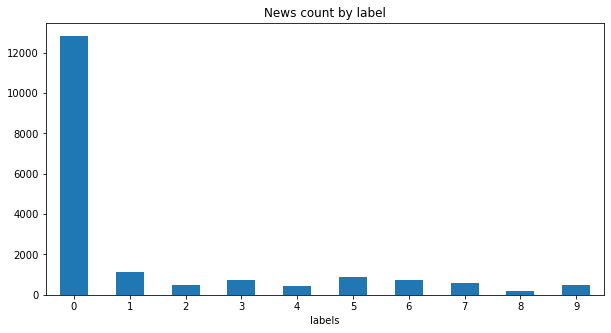

In [11]:
# Grouping별 뉴스 집계
grouped_labels = df.groupby(df['labels'])['title'].count()
grouped_labels.plot(kind='bar', title="News count by label", rot=0, figsize=(10,5))

In [12]:
# 고윳값의 갯수
n = df['labels'].nunique()

for i in range(n):
    is_News = (df['labels'] == i)
    
    if i == 0: df_group0 = df[is_News]
    if i == 1: df_group1 = df[is_News]
    if i == 2: df_group2 = df[is_News]
    if i == 3: df_group3 = df[is_News]
    if i == 4: df_group4 = df[is_News]
    if i == 5: df_group5 = df[is_News]
    if i == 6: df_group6 = df[is_News]
    if i == 7: df_group7 = df[is_News]
    if i == 8: df_group8 = df[is_News]
    if i == 9: df_group9 = df[is_News]

# Grouping 결과 확인
print("{Group0} \n", df_group0['title'].head(5))
print("{Group1} \n", df_group1['title'].head(5))
print("{Group2} \n", df_group2['title'].head(5))
print("{Group3} \n", df_group3['title'].head(5))
print("{Group4} \n", df_group4['title'].head(5))
print("{Group5} \n", df_group5['title'].head(5))
print("{Group6} \n", df_group6['title'].head(5))
print("{Group7} \n", df_group7['title'].head(5))
print("{Group8} \n", df_group8['title'].head(5))
print("{Group9} \n", df_group9['title'].head(5))

{Group0} 
 0           세진중공업 560억 규모 육상플랜트 모듈 수주
1    한국조선해양 지난해 수주액 100억 달러…목표 91% 달성
2             “경기 하락세 1분기에는 다소 완화될 듯”
3      울산 소상공인 81%는 ‘임차인’…보증금 네 번째 높아
4           공영쇼핑 ‘2021 건강하소 행복하소’ 이벤트
Name: title, dtype: object
{Group1} 
 45                                   한만두식품 설 선물세트 출시
149             푸르덴셜생명 사망·은퇴 동시 보장 100세 만족 달러연금보험 출시
218                  중국 시노팜 대표 예방 효과 79%… 부작용 가벼워 주장
238    GS25 안성맞춤 ‘수제딸기잼키트’ 출시 … 못난이 딸기 활용으로 생산농가 지원해
274                        수익률 시원찮네…대표 수익형 오피스텔이 어쩌다
Name: title, dtype: object
{Group2} 
 100              세계 최대 아프리카 자유무역지대 개시…과제 여전
163    400 만원 더 써봤자 세금감면 4만원대…생색내기 직장인 카드공제
172            3000만원 돌파한 비트코인…7년만에 ETF 나오나
181        농업인 국민연금보험료 지원…月 최대 4만5000원으로 인상
358             서울 아파트값 1곳 빼고 평당 2000만원 넘었다
Name: title, dtype: object
{Group3} 
 16                                 2021년 새해 부산 무엇이 달라지나
44                         부동산세 오르고 주식세 내려…새해 달라진 세금 QA
48    “핀셋 방식 금융자원 투입·부실화 예방할 때” 2021신년특집국내외 기관이 본 새해...
51    대부분 3% 안팎 성장 전망… 코로나 확산 땐 